In [1]:
import Pkg; Pkg.add(["QuadGK", "Plots"]);
using LinearAlgebra;
using Plots;default(l=2, size=(900,550), label=false);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


# Gram-Schmidt Orthogonalization on Vectors that are Functions

## The inputs / outputs to our implementations of QR factorization have been matrices

Like this implementation of modified Gram-Schmidt:

In [2]:
function mgs(A)
    _, n = size(A)
    Q = copy(A)
    R = zeros(eltype(A), n, n)
    for i in 1:n
        R[i,i] = norm(Q[:,i])
        Q[:,i] /= R[i,i]
        R[i,i+1:n] = Q[:,i]' * Q[:,i+1:n]
        Q[:,i+1:n] -= Q[:,[i]] * R[[i],i+1:n]
    end 
    return Q, R
end

mgs (generic function with 1 method)

## But $A$ and $Q$ can be treated as arrays of column vectors

Like this implementation of modified Gram-Schmidt:

In [3]:
function mgs_vectors(A::Array{V,1}) where V # V is the type of the column vector
    n = length(A) # the number of vectors
    Q = collect(copy.(A)) # copy all of the individual vectors
    R = zeros(eltype(V), n, n) 
    for i in 1:n
        R[i,i] = sqrt(dot(Q[i], Q[i])) # definition of norm(Q[i])
        Q[i] /= R[i,i]
        for j in i+1:n
            R[i,j] = dot(Q[i], Q[j])
            Q[j] -= Q[i] * R[i,j]
        end
    end
    return Q, R
end

mgs_vectors (generic function with 1 method)

### A demonstration that these are the same algorithm

In [4]:
m = 6; n = 4;
A = randn(4,4);
A_vecs = collect(A[:,i] for i in 1:n);

In [5]:
Q, R = mgs(A);

In [6]:
Q_vecs, R_vecs = mgs_vectors(A_vecs);

In [7]:
norm(R - R_vecs)

2.9893669801409083e-16

In [8]:
maximum(norm(Q[:,i] - Q_vecs[i]) for i in 1:n)

1.7554167342883506e-16

## What does `mgs_vectors` need the type `V` to provide? What doesn't it need?

**Does need:**

1. number type `eltype(V)`
2. vector addition `v + w`
3. vector scaling `a * v`
4. inner product `dot(v, w)`

**Does not need:**

1. The dimension of the space `length(v)`
2. Access to individual coefficients `v[i]`

- The things it _does need_ describe a vector space with an inner product.
- The things it _does not need_ are specific to $\mathbb{C}^m$ or $\mathbb{R}^m$.

## Recall that functions on an interval form a vector space

- We mentioned this in a lecture, but let's repeat:

> The set $V[a,b] = \{f: [a, b] \to \mathbb{C}\}$ is a vector space, with vector addition being the function $(f + g): x \mapsto f(x) + g(x)$ and vector scaling $(\alpha f): x \mapsto \alpha f(x).$

## Define a type for functions as vectors

- Let's give ourselves our own type for functions on an interval.  To emphasize that they are vectors, our type will use indexing notation to evaluate the function

In [9]:
# Define type Func for function taking values in field F
struct Func{F <: Number}
    _f # inner callable
end

Base.copy(f::Func{F}) where F = f
Base.eltype(::Type{<:Func{F}}) where F = F
# evaluate at one point
Base.getindex(f::Func{F},x) where F where T = F(f._f(x))
# evaluate at many points
Base.getindex(f::Func{F},v::AbstractVector{T}) where F where T = collect(F(f._f(x)) for x in v)

Our type can be evaluated at points, but notice that we can't get its length and we can't get `v[:]` AKA "all the components"

In [10]:
f = Func{Float64}(x->x^2);

In [11]:
f[[1,2,3]]

3-element Vector{Float64}:
 1.0
 4.0
 9.0

In [12]:
length(f)

LoadError: MethodError: no method matching length(::Func{Float64})
[0mClosest candidates are:
[0m  length([91m::Union{Base.KeySet, Base.ValueIterator}[39m) at ~/srv/rep/julia/usr/share/julia/base/abstractdict.jl:58
[0m  length([91m::Union{ZMQ._Message, Base.RefValue{ZMQ._Message}}[39m) at ~/.julia/packages/ZMQ/R3wSD/src/_message.jl:31
[0m  length([91m::Union{DataStructures.OrderedRobinDict, DataStructures.RobinDict}[39m) at ~/.julia/packages/DataStructures/vSp4s/src/ordered_robin_dict.jl:86
[0m  ...

In [13]:
f[:] 

LoadError: MethodError: no method matching ^(::Colon, ::Int64)
[0mClosest candidates are:
[0m  ^([91m::Union{AbstractChar, AbstractString}[39m, ::Integer) at ~/srv/rep/julia/usr/share/julia/base/strings/basic.jl:721
[0m  ^([91m::UniformScaling[39m, ::Number) at ~/srv/rep/julia/usr/share/julia/stdlib/v1.7/LinearAlgebra/src/uniformscaling.jl:318
[0m  ^([91m::Diagonal[39m, ::Integer) at ~/srv/rep/julia/usr/share/julia/stdlib/v1.7/LinearAlgebra/src/diagonal.jl:196
[0m  ...

## Implement the vector algebra rules for functions

> The set $V[a,b] = \{f: [a, b] \to \mathbb{C}\}$ is a vector space, with vector addition being the function $(f + g): x \mapsto f(x) + g(x)$ and vector scaling $(\alpha f): x \mapsto \alpha f(x).$

In [14]:
# import these operators so we can extend them
import Base: *,/,\,+,-

# Define scaling
*(a::N, v::Func{F}) where N <: Number where F = Func{F}(x -> a * v._f(x))
# Define addition
+(v::Func{F}, w::Func{F}) where F = Func{F}(x -> v._f(x) + w._f(x));

### With some syntactic sugar

In [15]:
# multiplication on the right = multiplication on the left
*(v::Func{F}, a::N) where F where N <: Number = a * v
# v / a = (1/a) * v
/(v::Func{F}, a::N) where F where N <: Number = (1/a) * v
# v - w = v + (-1 * w)
-(v::Func{F}, w::Func{F}) where F = v + ((-1) * w);

### In action

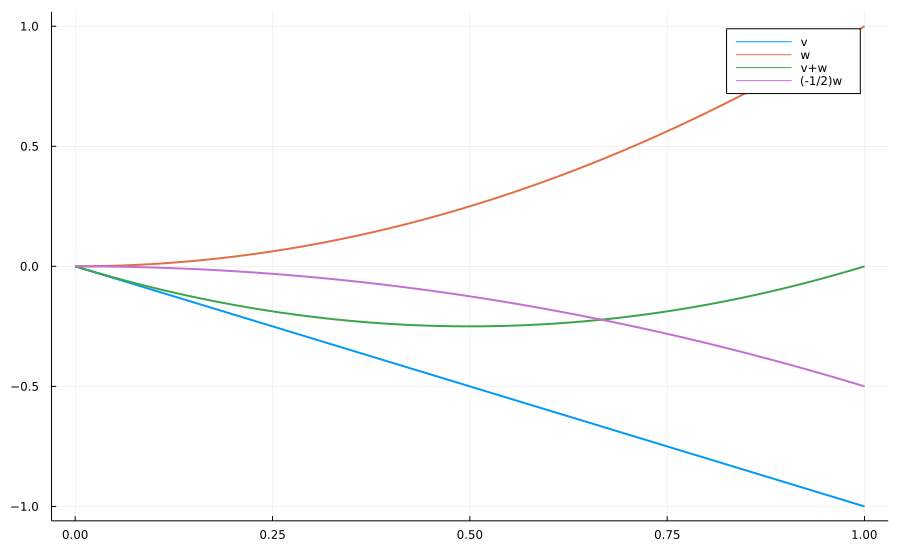

In [16]:
v = Func{Float64}(x -> -x)
w = Func{Float64}(x -> x^2)
vpw = v + w
sw = -0.5 * w
x = LinRange(0, 1, 200)

plot(x, [v[x] w[x] vpw[x] sw[x]], labels = ["v" "w" "v+w" "(-1/2)w"])

## We can define inner products on vectors spaces other than $\mathbb{C}^m$, including on functions on an interval

- Recall that an inner product has axioms, just like a vector space.  For a complex vector space $V$, if I can define an operation $(\cdot,\cdot):(V \otimes V) \to \mathbb{C}$ that satisfies the inner product axioms, then $(\cdot,\cdot)$ is an inner product.  Those axioms again are:

1. $(u, v) = \overline{(v, u)}$ (conjugate symmetry)
2. $(u, \alpha v) = \alpha(u, v)$ and $(u, v + w) = (u, v) + (u, w)$ (linearity in the second argument, which combined with property 1 implies conjugate linearity in the first argument)
3. $(u, u) \geq 0$ with $[(u, u) = 0] \Leftrightarrow [u = 0]$ (positive definiteness)

## The simplest inner product on functions is the $L^2$ inner product

- Consider just continuous functions on the interval $[a,b]$,

$$C^0[a,b] = \{f:[a,b] \to \mathbb{C}, \text{such that } f \text{ is continuous}\}.$$

- Define the operation $(\cdot,\cdot): (C^0[a,b] \otimes C^0[a,b]) \to \mathbb{C}$ by
$$(f, g) = \int_a^b \overline{f(x)} g(x)\ dx.$$

- This is the **$L^2$ inner product**.  Verifying the inner product axioms is an exercise you should try if you're not convinced.

- _Every_ inner product defines a norm, so there is an $L^2$ norm on $C^0[a,b]$,

$$\|f\|_{L^2} = \left\{\int_a^b |f(x)|^2\ dx\right\}^{1/2}.$$

## Let's (approximately) implement the $L^2$ inner product

- Methods that evaluate $f(x)$ at a finite number of points in order to estimate $\int f(x)\ dx$ are called _quadrature_ rules.  Let's get some numerical quadrature methods from the `QuadGK` package.  Example usage:

In [17]:
using QuadGK

integral, err = quadgk(x -> exp(-x^2 / 2) / sqrt(2 * π), -10, 10)

(1.0, 1.0428675273326288e-9)

### Equations to code

$$(f, g) = \int_a^b \overline{f(x)} g(x)\ dx.$$

In [18]:
function L2_inner_product(f, g; a=-1, b=1, rtol=1.e-12)
    val, _ = quadgk(x -> conj(f(x)) * g(x), a, b,  rtol=rtol)
    return val
end

L2_inner_product (generic function with 1 method)

In [19]:
L2_inner_product(x -> -x, x-> x^3) # ∫₋₁,₁ (-x)*x³ dx = -∫₋₁,₁ x⁴ dx = -(1/5)(1⁵ - (-1)⁵) = -1/5 * 2 = -2/5

-0.39999999999999997

## Define the $L^2$ inner product to be `dot` for our function type

In [20]:
import LinearAlgebra: dot

dot(v::Func{F}, w::Func{F}) where F = L2_inner_product(v._f, w._f)

dot (generic function with 74 methods)

## Basis functions with large cosine similarity have problems

- The angle between the two angles on the left is $1$ degree: how well can you tell them apart?
- The angle (defined as $(f,g) / (\|f\|\ \|g\|)$) between $x^{55}$ and $x^{57}$ is about $1$ degree: how well can you tell them apart?

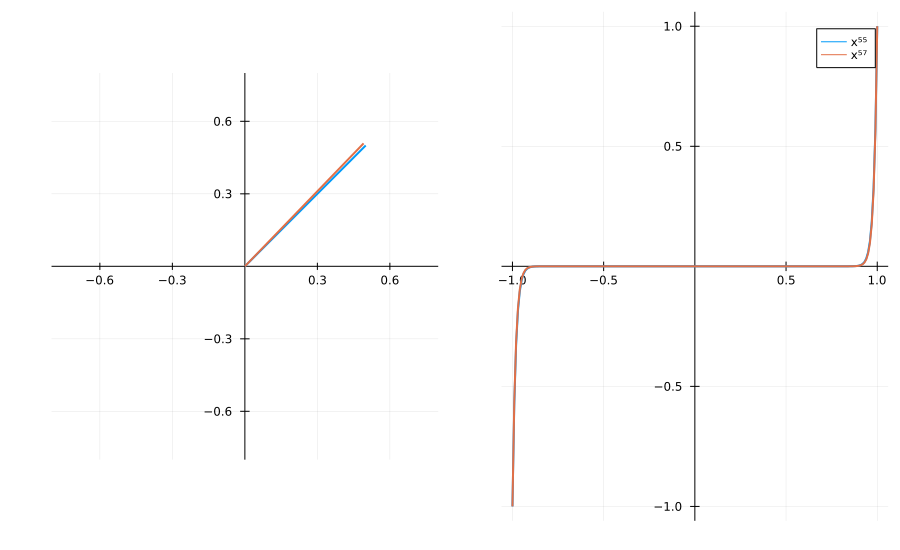

In [21]:
v = [0.5,0.5]
θ = π / 180
c, s = [cos(θ), sin(θ)]
w = [[c,s] [-s,c]] * v
p = plot([[0,v[1]] [0,w[1]]], [[0,v[2]] [0,w[2]]]
    , aspect_ratio = :equal
    , lim=(-.8,.8)
    , framestyle = :origin
    )

f = Func{Float64}(x->x^55)
g = Func{Float64}(x->x^57)
x = LinRange(-1,1,200)
q = plot(x, [f[x] g[x]], label=["x⁵⁵" "x⁵⁷"], framestyle=:origin)
plot(p,q,layout=(1,2))

## Using Gram-Schmidt to create orthonormal bases

Suppose we want a good basis of functions for $\mathcal{P}^5[-1,1]$: polynomials up to degree 5 on the interval $[-1,1]$.

### Start with a basis that is easy to define and evaluate: the _monomial basis_

The monomial basis is $\{x^0, x^1, x^2, x^3, x^4, x^5\}$

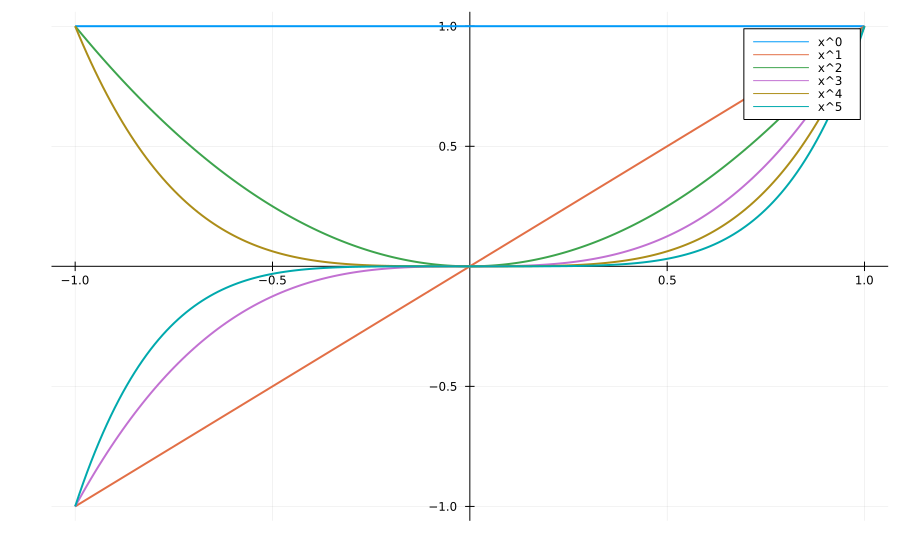

In [22]:
p = 5
A = collect(Func{Float64}(x->x^i) for i in 0:p);
x = LinRange(-1,1,200)
plot(x, hcat(collect(A[i][x] for i in 1:p+1)...)
    , framestyle=:origin
    , label=hcat(collect("x^$i" for i in 0:p)...))

### Run Gram-Schmidt to Construct an Orthonormal Basis

In [23]:
Q, R = mgs_vectors(A);

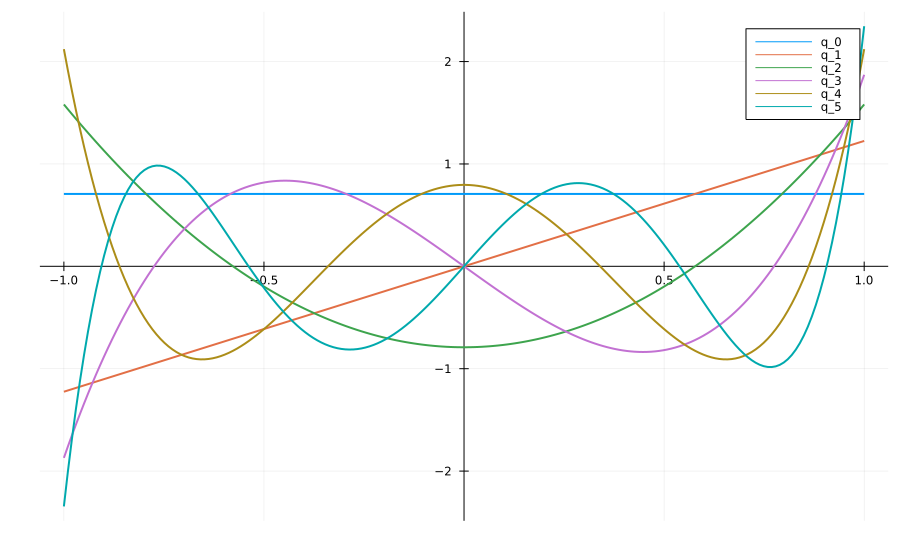

In [24]:
plot(x, hcat(collect(Q[i][x] for i in 1:p+1)...)
    , framestyle=:origin
    , label=hcat(collect("q_$i" for i in 0:p)...))

These polynomials are scaled versions of the [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials)

## We can orthogonalize nonpolynomials using Gram-Schmidt

Here we orthogonalize the set $\{e^x, \tanh x, \sin x, \text{ReLU} x, e^{-x^2}\}$

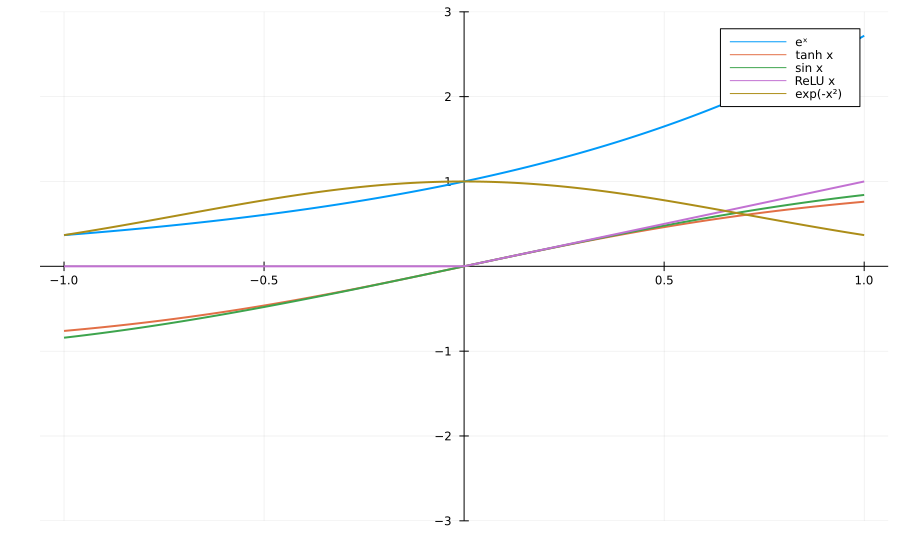

In [25]:
B = map(f -> Func{Float64}(f),[x -> exp(x), x -> tanh(x), x -> sin(x), x -> if (x < 0) 0 else x end, x -> exp(-x^2)]);
x = LinRange(-1, 1, 200)
plot(x, hcat(collect(B[i][x] for i in 1:5)...), framestyle=:origin, ylim=(-3,3), label=["eˣ" "tanh x" "sin x" "ReLU x" "exp(-x²)"])

In [26]:
Q, R = mgs_vectors(B);

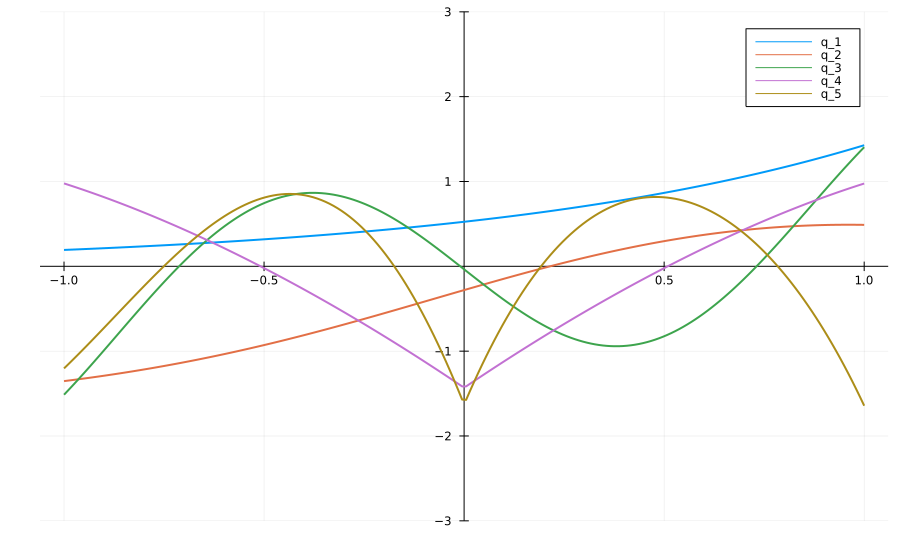

In [27]:
plot(x, hcat(collect(Q[i][x] for i in 1:5)...), framestyle=:origin, ylim=(-3,3), label=["q_1" "q_2" "q_3" "q_4" "q_5"])

## Notes on HW2 Problem 7

Do not use `QuadGK` to approximate the $L^2$ inner product.  You should select $m$ evenly spaced points $\{x_i\}_{i=1}^m$ in $[a,b]$, approximate the function $f(x)$ as the vector $\hat{f}$ of values $[\hat{f}_1, \dots, \hat{f}_m]$ where $\hat{f}_i = f(x_i)$, and approximate the inner-product as

$$(f,g) \approx \frac{(b-a)}{m} \hat{f}^* \hat{g}.$$